In [1]:
from time import time # 用于计算运行时间
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib import offsetbox # 定义图形box的格式
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 调整notebook中输出图片的清晰度，使得在retina屏幕上显示得更清楚


digits = datasets.load_digits(n_class=6)
print digits

{'images': array([[[  0.,   0.,   5., ...,   1.,   0.,   0.],
        [  0.,   0.,  13., ...,  15.,   5.,   0.],
        [  0.,   3.,  15., ...,  11.,   8.,   0.],
        ..., 
        [  0.,   4.,  11., ...,  12.,   7.,   0.],
        [  0.,   2.,  14., ...,  12.,   0.,   0.],
        [  0.,   0.,   6., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   5.,   0.,   0.],
        [  0.,   0.,   0., ...,   9.,   0.,   0.],
        [  0.,   0.,   3., ...,   6.,   0.,   0.],
        ..., 
        [  0.,   0.,   1., ...,   6.,   0.,   0.],
        [  0.,   0.,   1., ...,   6.,   0.,   0.],
        [  0.,   0.,   0., ...,  10.,   0.,   0.]],

       [[  0.,   0.,   0., ...,  12.,   0.,   0.],
        [  0.,   0.,   3., ...,  14.,   0.,   0.],
        [  0.,   0.,   8., ...,  16.,   0.,   0.],
        ..., 
        [  0.,   9.,  16., ...,   0.,   0.,   0.],
        [  0.,   3.,  13., ...,  11.,   5.,   0.],
        [  0.,   0.,   0., ...,  16.,   9.,   0.]],

       ..., 
       [[ 

In [2]:
print digits.data
print digits.target

[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   0. ...,   9.   0.   0.]
 [  0.   0.   0. ...,   4.   0.   0.]
 [  0.   0.   6. ...,   6.   0.   0.]]
[0 1 2 ..., 4 4 0]


In [3]:
data,target = datasets.load_digits(n_class=6, return_X_y=True)
print data
print target

[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   0. ...,   9.   0.   0.]
 [  0.   0.   0. ...,   4.   0.   0.]
 [  0.   0.   6. ...,   6.   0.   0.]]
[0 1 2 ..., 4 4 0]


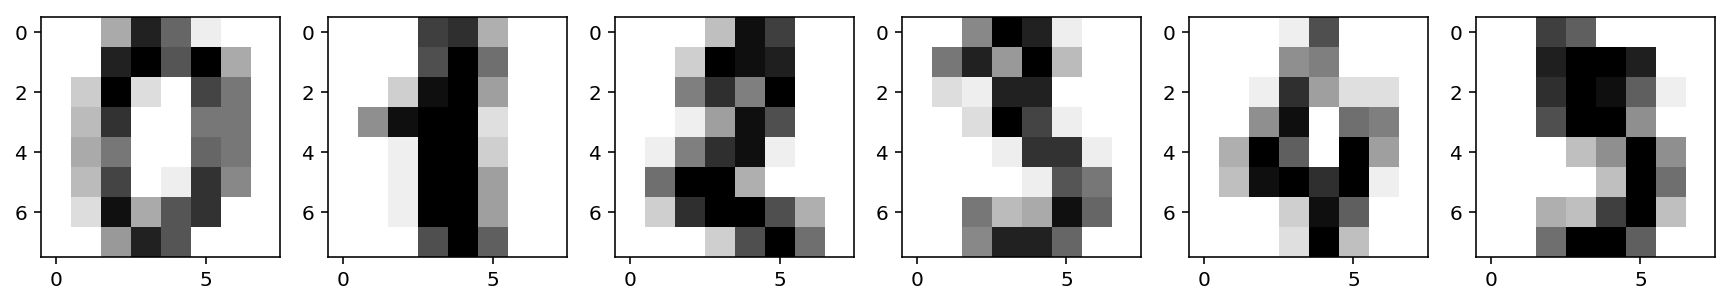

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 15))
for i,ax in zip(range(6),axes.flatten()):
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r)
plt.show()

In [5]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

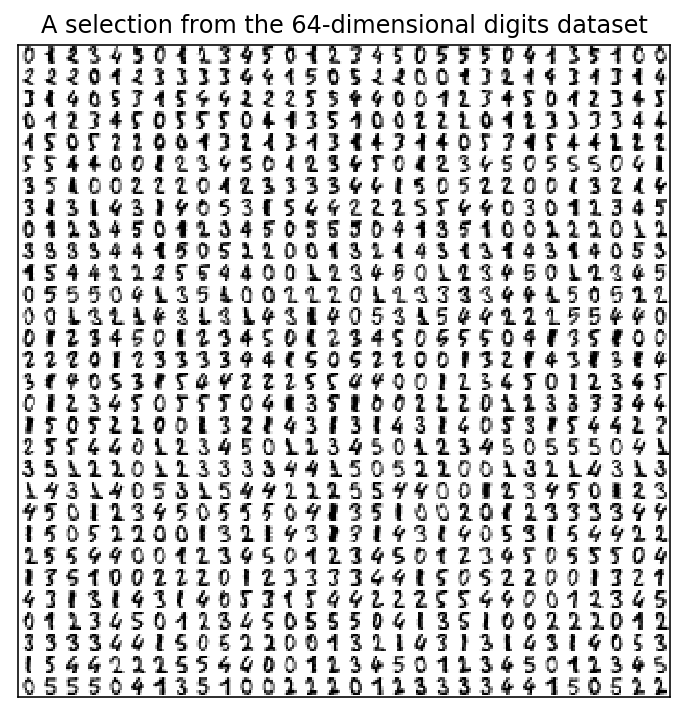

In [6]:
n_img_per_row = 30 # 每行显示30个图片

# 整个图形占 300*300，由于一张图片为8*8，所以每张图片周围包了一层白框，防止图片之间互相影响
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))

for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))  
plt.figure(figsize=(6,6))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

In [7]:
# 首先定义函数画出二维空间中的样本点，输入参数：1.降维后的数据；2.图片标题

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min) # 对每一个维度进行0-1归一化，注意此时X只有两个维度
    
    plt.figure(figsize= (6,6)) # 设置整个图形大小
    ax = plt.subplot(111)
    colors = ['#5dbe80','#2d9ed8','#a290c4','#efab40','#eb4e4f','#929591']
    
    # 画出样本点
    for i in range(X.shape[0]): # 每一行代表一个样本
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 #color=plt.cm.Set1(y[i] / 10.),
                 color=colors[y[i]],
                 fontdict={'weight': 'bold', 'size': 9})  # 在样本点所在位置画出样本点的数字标签
    
    # 在样本点上画出缩略图，并保证缩略图够稀疏不至于相互覆盖
    # 只有matplotlib 1.0版本以上，offsetbox才有'AnnotationBbox'，所以需要先判断是否有这个功能
    if hasattr(offsetbox, 'AnnotationBbox'): 
        shown_images = np.array([[1., 1.]])  # 假设最开始出现的缩略图在(1,1)位置上
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1) # 算出样本点与所有展示过的图片（shown_images）的距离
            if np.min(dist) < 4e-3: # 若最小的距离小于4e-3，即存在有两个样本点靠的很近的情况，则通过continue跳过展示该数字图片缩略图
                continue
            shown_images = np.r_[shown_images, [X[i]]] # 展示缩略图的样本点通过纵向拼接加入到shown_images矩阵中
            
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
            
    plt.xticks([]), plt.yticks([]) # 不显示横纵坐标刻度
    if title is not None: 
        plt.title(title)

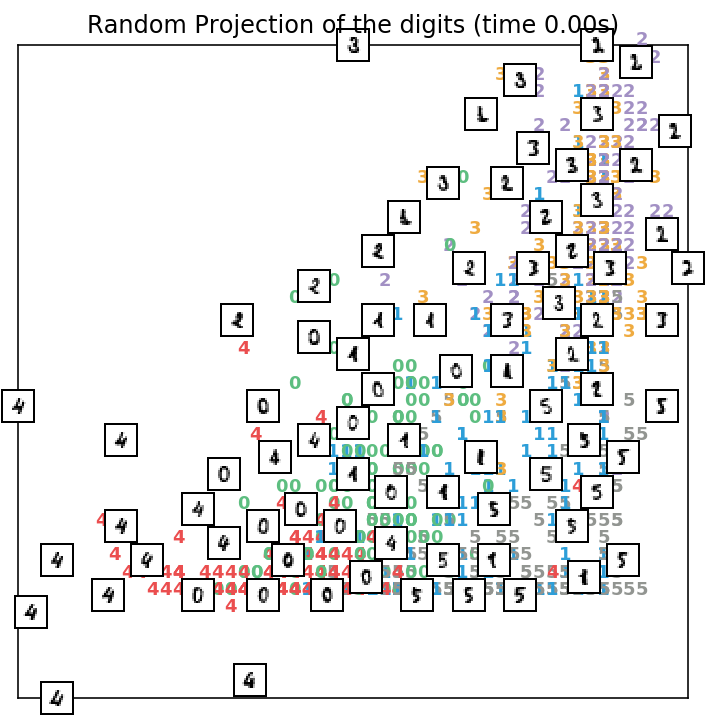

In [8]:
t0 = time() 
rp = random_projection.SparseRandomProjection(n_components=2, random_state=66)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, 
               "Random Projection of the digits (time %.2fs)" %
               (time() - t0))

[ 0.19268752  0.16491423]


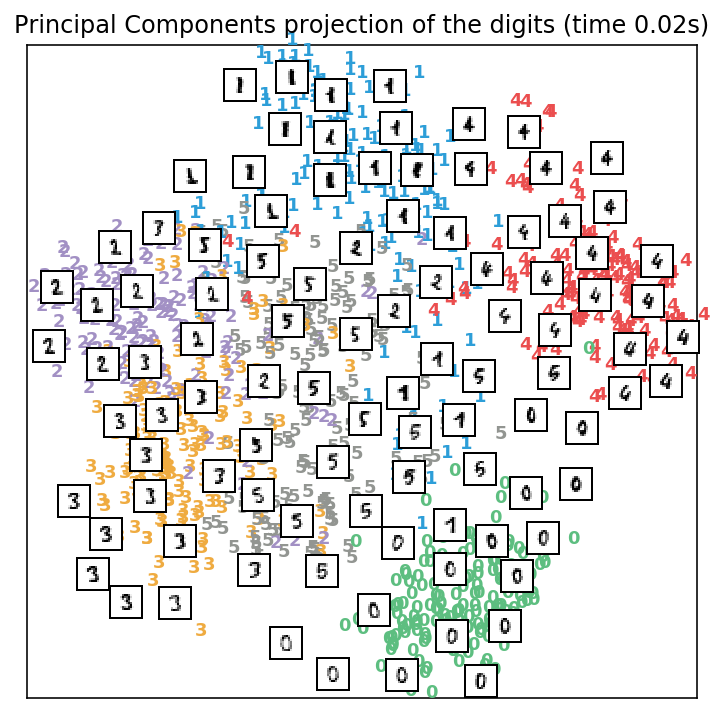

In [9]:
t0 = time()
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))
print pca.explained_variance_ratio_ # 每一个成分对原数据的方差解释了百分之多少

[ 0.02632557  0.19263253]


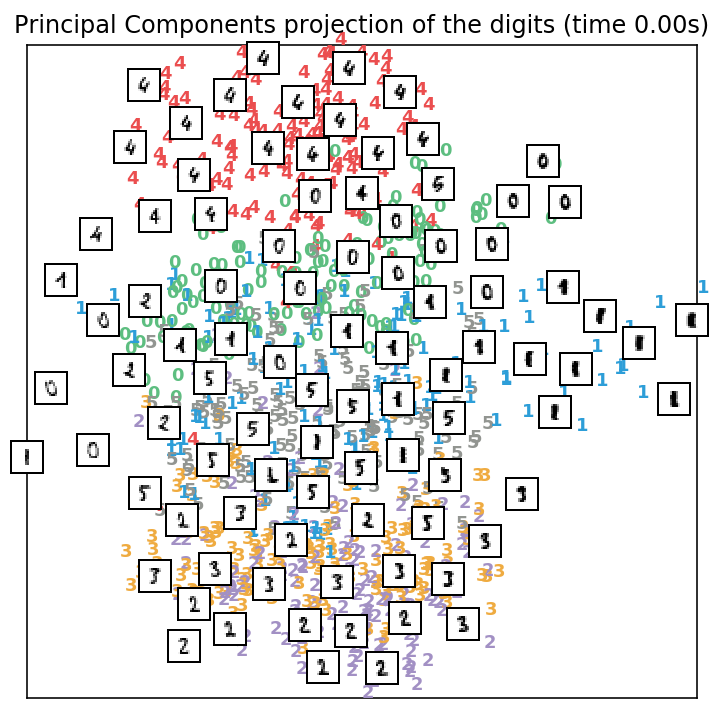

In [10]:
t0 = time()
svd = decomposition.TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)
plot_embedding(X_svd,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))
print svd.explained_variance_ratio_

[ 0.3812868   0.27151737]


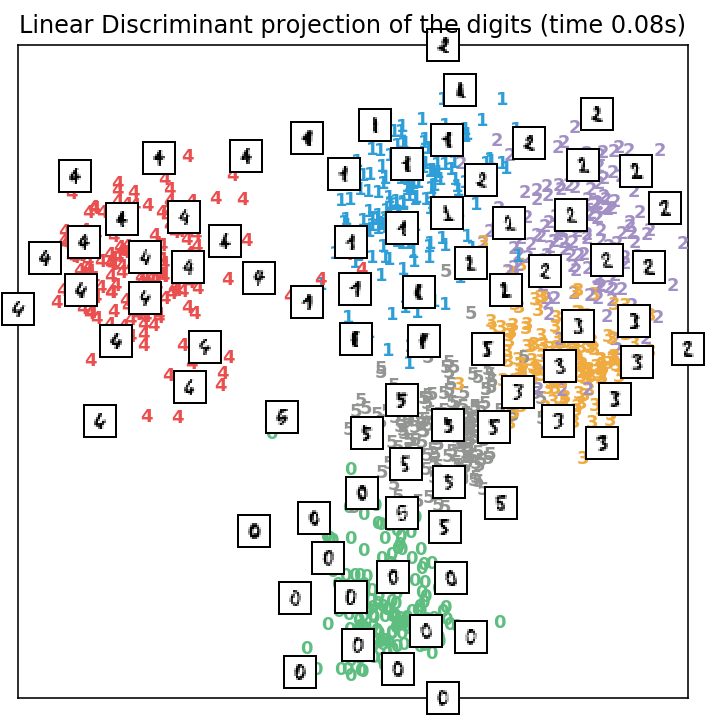

In [11]:
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # 使得X可逆
t0 = time()
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))
print lda.explained_variance_ratio_

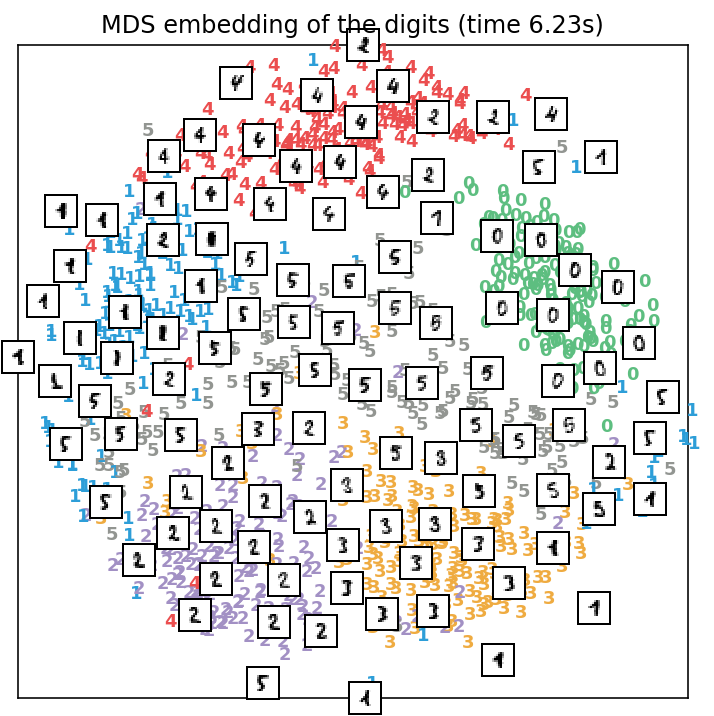

In [12]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

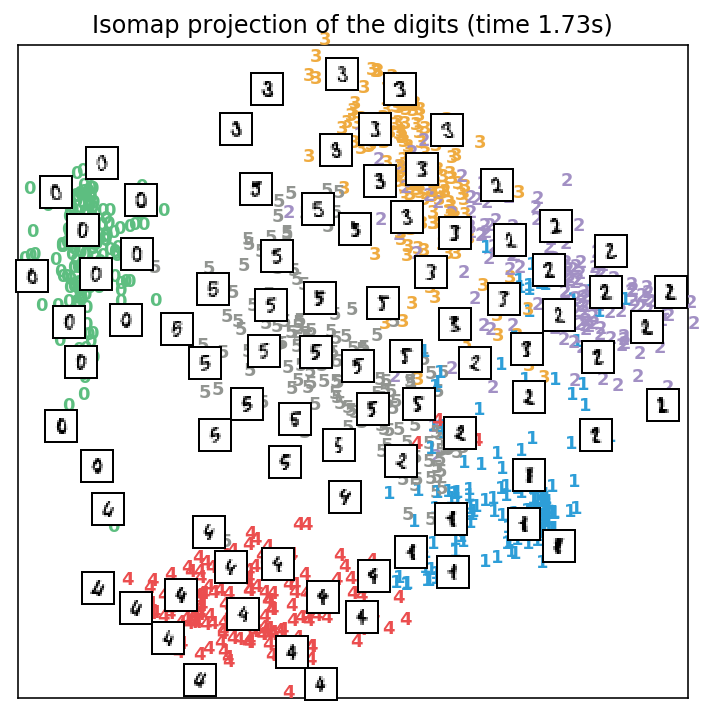

In [13]:
t0 = time()
iso = manifold.Isomap(n_neighbors, n_components=2)
X_iso = iso.fit_transform(X)
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Reconstruction error: 1.63544e-06


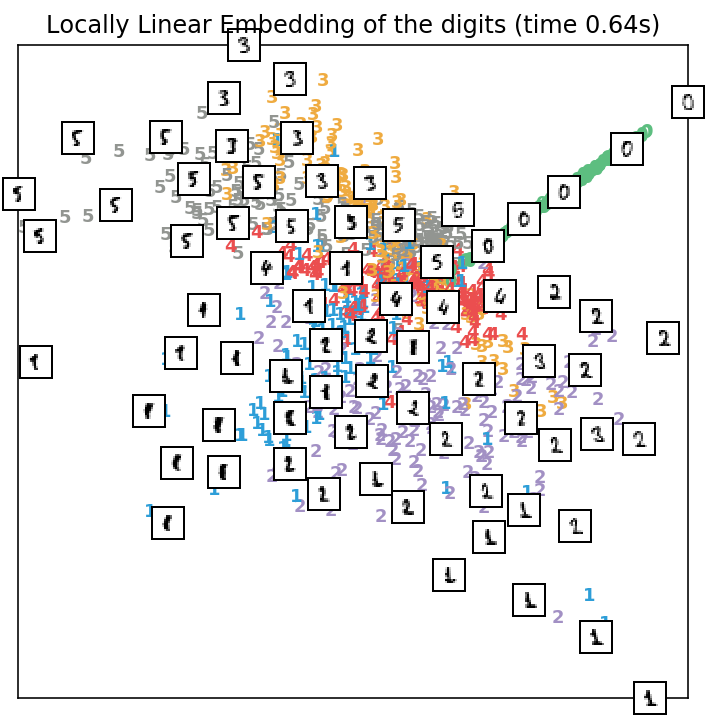

In [14]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='standard')
t0 = time() 
X_lle = clf.fit_transform(X)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

Reconstruction error: 0.360653


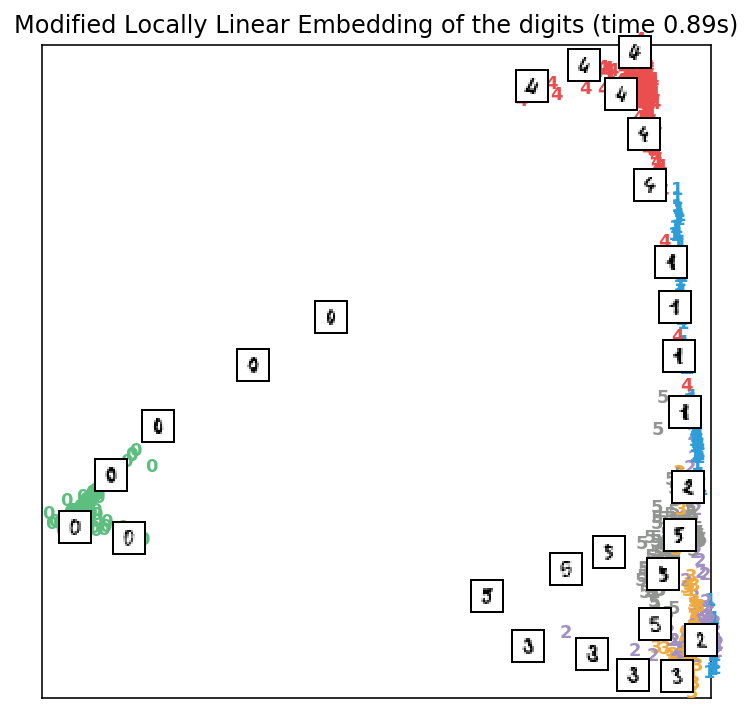

In [15]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

Reconstruction error: 0.212802


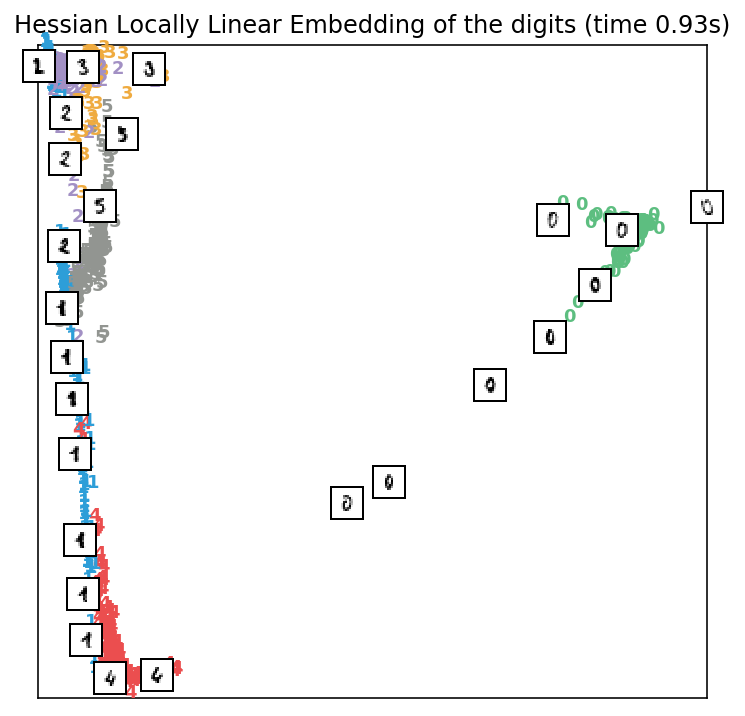

In [16]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
plot_embedding(X_hlle,
               "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

Reconstruction error: 0.212804


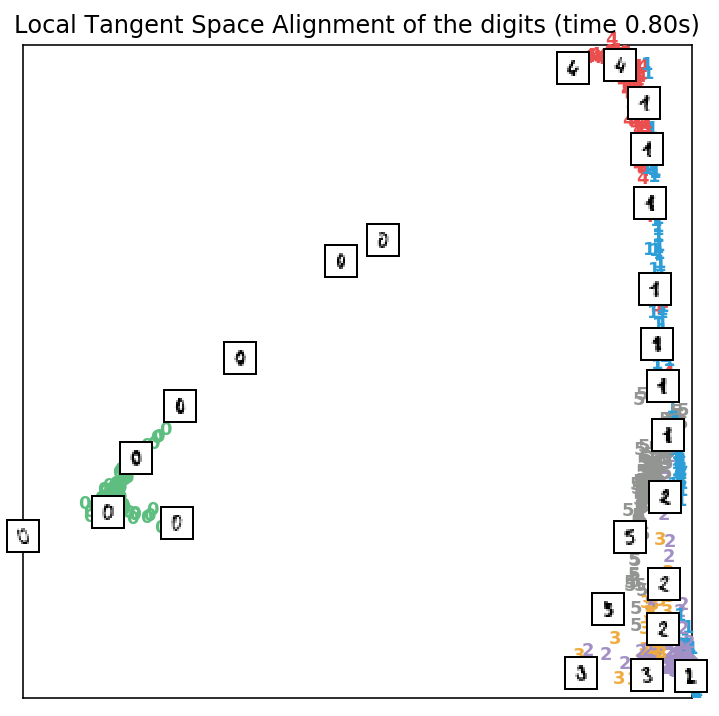

In [17]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
plot_embedding(X_ltsa,
               "Local Tangent Space Alignment of the digits (time %.2fs)" %
               (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

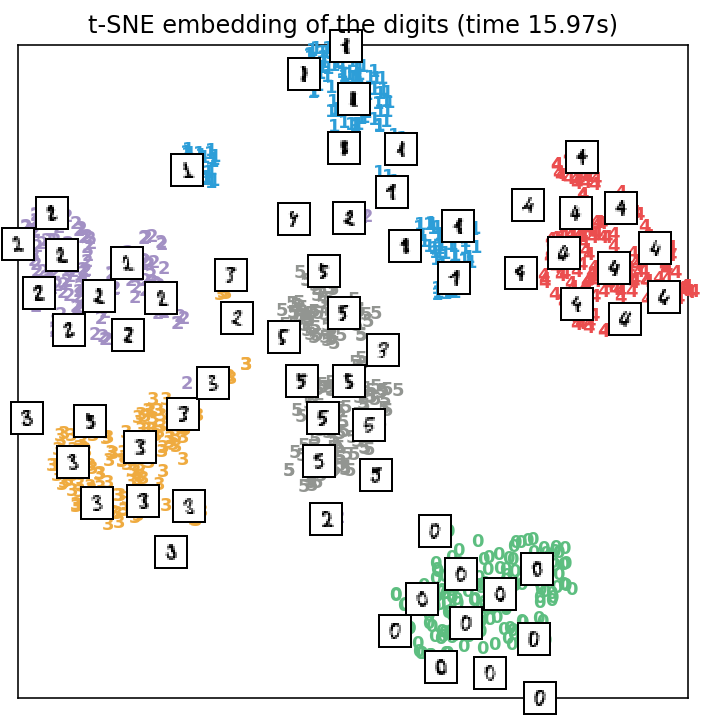

In [18]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=10) # 生成tsne实例
t0 = time()  # 执行降维之前的时刻
X_tsne = tsne.fit_transform(X) # 降维得到二维空间中的数据
plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" % (time() - t0)) # 画出降维后的嵌入图形
plt.show()

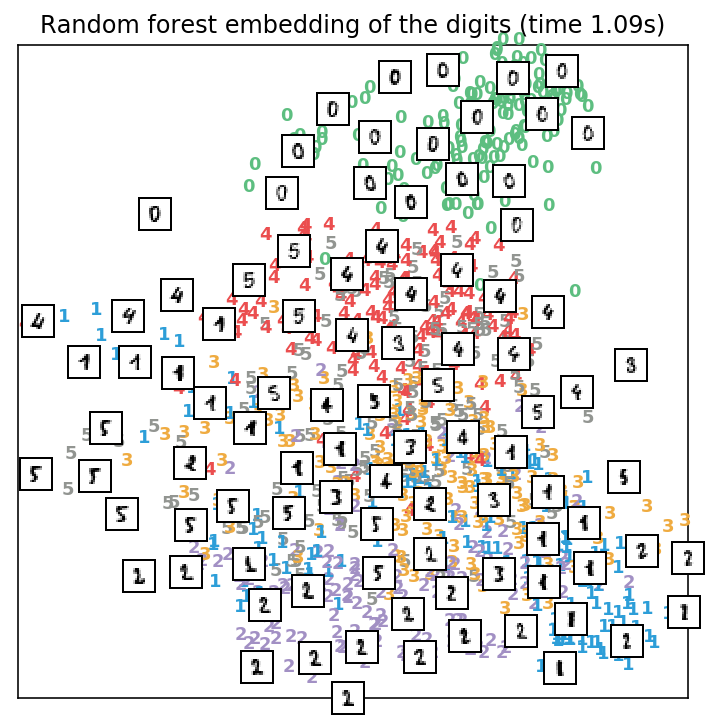

In [19]:
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0, max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)
plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

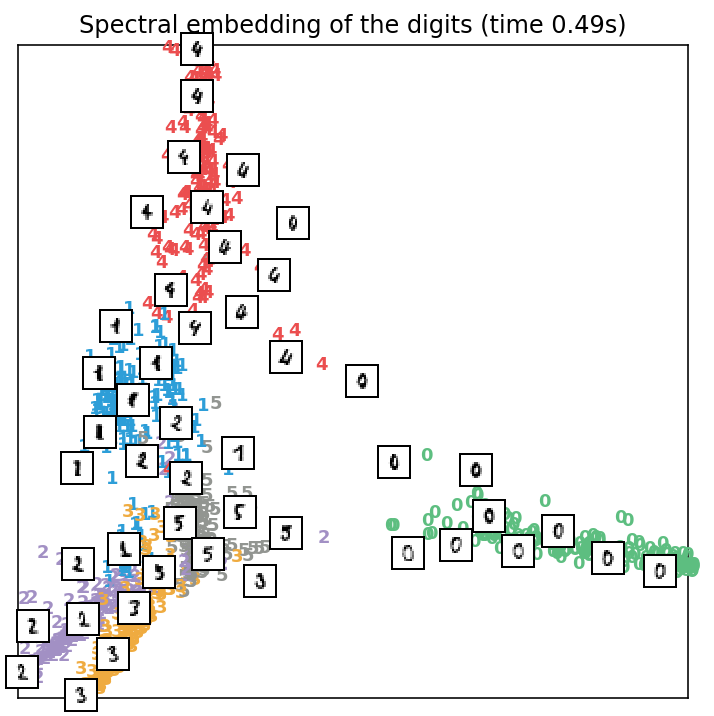

In [20]:
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)
plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))